# CS 7641 HW3 Code - Unsupervised Learning

This file will provide analysis clustering and dimensionality reduction techniques for for two datasets.

Datasets: Credit Card Dataset, Bank Marketing.

Clustering Techniques: k-Means, Expectation Maximization.
Dimensionality Reduction Techniques: PCA, ICA, RCA, RFC

# 1. Data Load and Preprocessing

First we load the data! Please save the datasets to your local machine and change the current directory to a file where you have the data stored.

In [1]:
import os
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


### Load the Credit Card Data

In [2]:
## Read the datafile. It should be present in same directory as this IPYNB file

df_cc = pd.read_csv('CreditCardDefaultData.csv').astype('category')
print("Data has",len(df_cc),"rows and", len(df_cc.columns),"columns.")
if df_cc.isnull().values.any():
    print("Warning: Missing Data")
df_cc.head()
#df_cc.describe(include='all')

('Data has', 30000, 'rows and', 25, 'columns.')


ID LIMIT_BAL SEX EDUCATION MARRIAGE AGE PAY_0 PAY_2 PAY_3 PAY_4  ...  \
0  1   20000.0   2         2        1  24     2     2    -1    -1  ...   
1  2  120000.0   2         2        2  26    -1     2     0     0  ...   
2  3   90000.0   2         2        2  34     0     0     0     0  ...   
3  4   50000.0   2         2        1  37     0     0     0     0  ...   
4  5   50000.0   1         2        1  57    -1     0    -1     0  ...   

  BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5  \
0       0.0       0.0       0.0      0.0    689.0      0.0      0.0      0.0   
1    3272.0    3455.0    3261.0      0.0   1000.0   1000.0   1000.0      0.0   
2   14331.0   14948.0   15549.0   1518.0   1500.0   1000.0   1000.0   1000.0   
3   28314.0   28959.0   29547.0   2000.0   2019.0   1200.0   1100.0   1069.0   
4   20940.0   19146.0   19131.0   2000.0  36681.0  10000.0   9000.0    689.0   

  PAY_AMT6 default.payment.next.month  
0      0.0                          1  
1   2000.0                          1  
2   5000.0                          0  
3   1000.0                          0  
4    679.0                          0  

[5 rows x 25 columns]

Now that the credit card data is loaded, we need to do some preprocessing. We have three categorical variables Sex, Education and Marriage. We will create dummy binary variables for each of these categorical variables using one-hot encoding. Also, we would remove the ID column from the dataset in order to avoid any noise from this variable during prediction.

In [3]:
col_1hot = ['SEX','EDUCATION','MARRIAGE']
df_1hot = df_cc[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_cc.drop(col_1hot,axis=1)
df_cc = pd.concat([df_1hot,df_others],axis=1)
column_order = list(df_cc)
column_order.insert(0, column_order.pop(column_order.index('default.payment.next.month')))
df_cc = df_cc.loc[:, column_order]  #move the target variable to the front


numericcols = ['AGE','LIMIT_BAL','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df_num = df_cc[numericcols]
df_num = df_num.apply(pd.to_numeric) #Convert all columns to numeric, since it is read as categorical
df_cc_categorical = df_cc.drop(numericcols,axis=1)
df_cc = pd.concat([df_cc_categorical,df_num],axis=1)

df_cc.drop(['ID'], axis=1, inplace=True) #drop ID variable

df_cc.head()

default.payment.next.month  SEX_1  SEX_2  EDUCATION_0  EDUCATION_1  \
0                          1      0      1            0            0   
1                          1      0      1            0            0   
2                          0      0      1            0            0   
3                          0      0      1            0            0   
4                          0      1      0            0            0   

   EDUCATION_2  EDUCATION_3  EDUCATION_4  EDUCATION_5  EDUCATION_6  ...  \
0            1            0            0            0            0  ...   
1            1            0            0            0            0  ...   
2            1            0            0            0            0  ...   
3            1            0            0            0            0  ...   
4            1            0            0            0            0  ...   

   BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0      689.0        0.0        0.0        0.0       0.0     689.0       0.0   
1     2682.0     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2    13559.0    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3    49291.0    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4    35835.0    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  
0       0.0       0.0       0.0  
1    1000.0       0.0    2000.0  
2    1000.0    1000.0    5000.0  
3    1100.0    1069.0    1000.0  
4    9000.0     689.0     679.0  

[5 rows x 34 columns]

In [4]:
#df_phish.to_csv("PhishingWebsitesData_preprocessed.csv")

We now have a file with no missing data in the format [y, X] where all features are binary {0,1}. The credit card data is ready to go! Now we move on to loading the Bank Marketing data.

### Load the Bank Marketing Data

In [5]:
## ## Read the datafile. It should be present in same directory as this IPYNB file

df_bank = pd.read_csv('BankMarketingData.csv')
print("Data has",len(df_bank),"rows and", len(df_bank.columns),"columns.")
if df_bank.isnull().values.any():
    print("Warning: Missing Data")
#df_bank.head()
#df_bank.describe(include='all')

('Data has', 45307, 'rows and', 21, 'columns.')


This dataset needs some preprocessing love too. We will convert all categorical columns using one hot encoding. Additionally, we will standardize all of the numeric features and we will convert the target variable from {no,yes} to {0,1}. It should be noted that the feature 'pdays' is numeric but contains values that are '999' if the customer was not called before. It may be worth while to create a new feature that defines whether or not {0,1} a customer had been called before. In the current state the '999' values may be outliers.

In [6]:
col_1hot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_1hot = df_bank[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_bank.drop(col_1hot,axis=1)
df_bank = pd.concat([df_others,df_1hot],axis=1)
column_order = list(df_bank)
column_order.insert(0, column_order.pop(column_order.index('y')))
df_bank = df_bank.loc[:, column_order]
df_bank['y'].replace("no",0,inplace=True)
df_bank['y'].replace("yes",1,inplace=True)
df_bank['y'] = df_bank['y'].astype('category')

numericcols = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
df_num = df_bank[numericcols]
df_bank_categorical = df_bank.drop(numericcols,axis=1)
df_bank = pd.concat([df_bank_categorical,df_num],axis=1)

df_bank.drop(['pdays'], axis=1, inplace=True) #Drop pdays variable because it is highly correlated to our response variable
#df_bank.head()

In [7]:
#df_bank.to_csv("BankMarketingData_preprocessed.csv")

Now we have successfully loaded and processed both datasets. We are ready to start the ML!

# 2. Helper Functions

### Data Loading and Function Prep

Before we get into the algorithms, let's define some helper functions that will be used across all of the models and both datasets. We will define a function to load the data (not really necessary in a Jupyter notebook, but good if this is exported as a .py for later use). We will also define a function that plots the learning curve (training and cross validation score as a function of training examples) of an estimator (classification model). Finally, we define functions to output final model scores using an untouched test dataset.

In [244]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import itertools
import timeit
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def import_data():

    X1 = np.array(df_cc.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_cc.values[:,0],dtype='int64')
    X2 = np.array(df_bank.values[:,1:-1],dtype='int64')
    Y2 = np.array(df_bank.values[:,0],dtype='int64')
    return X1, Y1, X2, Y2


def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    y_train_pred = clf.predict(X_train)
    auc_train = roc_auc_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    cm_train = confusion_matrix(y_train, y_train_pred)
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Train Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("F1 Score:  "+"{:.2f}".format(f1_train))
    print("Accuracy:  "+"{:.2f}".format(accuracy_train)+"     AUC:       "+"{:.2f}".format(auc_train))
    print("Precision: "+"{:.2f}".format(precision_train)+"     Recall:    "+"{:.2f}".format(recall_train))
    
    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()    

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

# def pairwiseDistCorr(X1,X2):
#     assert X1.shape[0] == X2.shape[0]
    
#     d1 = pairwise_distances(X1)
#     d2 = pairwise_distances(X2)
#     return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

## Neural Network Classifier

This section will build a forward-feed neural network which computes weights via backpropagation (a multilayer perceptron). The main hyperparameter will be number of hidden nodes in a network defined by a single hidden layer, while others that could be searched over in grid search are activation function, and learning rate. This will be used later when we compare neural networks built from different combinations of features after clustering and dimensionality reduction

In [68]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,150,30).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(accuracy_score(y_test, y_pred_test))
            f1_train.append(accuracy_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train Accuracy')
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    param_grid = {'hidden_layer_sizes': h_units}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',learning_rate_init=0.05,random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes']

# 3. Clustering

## k-Means Clustering

This section will implement k-means clustering for both datasets. Our objectives are to:
1. Determine the best number of clusters for each dataset by using the elbow inspection method on silhouette score.
2. Describe the attributes which make up each cluster.
3. Score each cluster with an accuracy since technically we do have labels available for these datasets (labels are not used when determining clusters).

Since k-Means is susceptible to get stuck in local optima due to the random selection of initial cluster centers, I will report the average metrics over 5 models for each number of k clusters.

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_kmeans(X,y,title):

    kclusters = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; wcss = [];

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        #sil_scores.append(sil_score(X, km.labels_))
        wcss.append(km.inertia_)
        y_mode_vote = cluster_predictions(y,km.labels_)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, km.labels_))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, wcss)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    #plt.ylabel('Avg Silhouette Score')
    plt.ylabel('Within Cluster Sum of Squares Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores KMeans: '+ title)
    plt.show()

    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores KMeans: '+ title)
    plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('KMeans Training Time: '+ title)
    plt.show()
    
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

def viz_clusters(X_norm, y, range_n_clusters, f1, f2, title):
    X_norm = pd.DataFrame(X_norm)
    for n_clusters in range_n_clusters:
        fig = plt.gcf()
        #fig.set_size_inches(7, 7)
        ax = fig.add_subplot(111)

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_norm)
        #clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_norm)
        cluster_labels = clusterer.labels_
        print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

        # 2nd Plot showing the actual clusters formed
        colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
        plt.scatter( X_norm.iloc[:, f1], X_norm.iloc[:, f2], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        plt.scatter(centers[:, f1], centers[:, f2], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax.scatter( c[f1], c[f2], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax.set_title("Clusters plot for K-means clustering for " + title +
                      " with n_clusters = %d" % n_clusters)
        ax.set_xlabel("Feature space for the 1st feature")
        ax.set_ylabel("Feature space for the 2nd feature")

#         plt.suptitle(("Clusters plot for K-means clustering for " + title +
#                       " with n_clusters = %d" % n_clusters))

        plt.show()  
    


In [260]:
#Break Credit Card Dataset into train, validation and test
ccX,ccY,bankX,bankY = import_data()
#X_train, X_test, ccY_train, ccY_test = train_test_split(np.array(ccX),np.array(ccY), test_size=0.20, random_state =3)
scaler = StandardScaler().fit(ccX)
ccX_scaled = scaler.transform(ccX)
#ccX_test_scaled = scaler.transform(X_test)

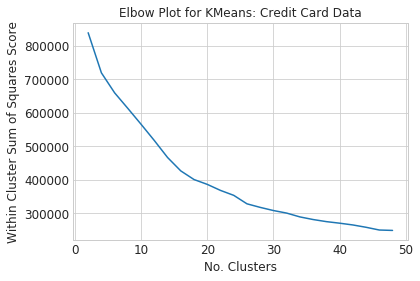

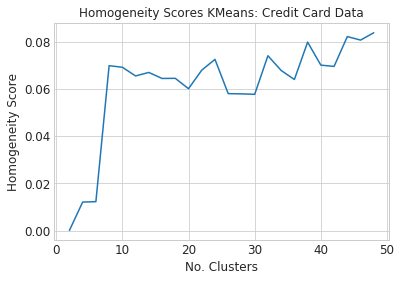

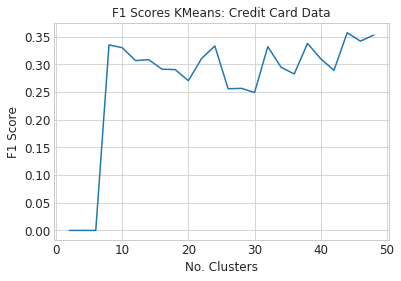

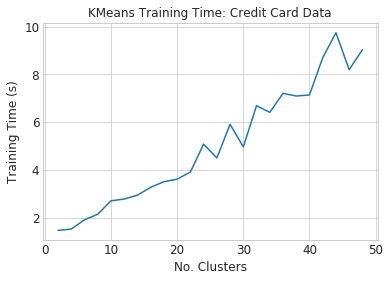

In [14]:
run_kmeans(ccX_scaled,ccY,'Credit Card Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.20
No. Iterations to Converge: 16
F1 Score:  0.34
Accuracy:  0.80     AUC:       0.60
Precision: 0.64     Recall:    0.23
*****************************************************


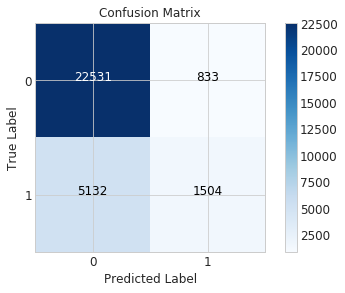

In [15]:
km = KMeans(n_clusters=8,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,ccX_scaled,ccY)

NMI score: 0.008201


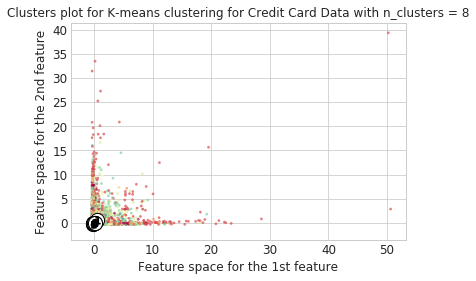

In [300]:
viz_clusters(ccX_scaled,ccY,[8],29,30,"Credit Card Data")

In [246]:
#X_train, X_test, bankY_train, bankY_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state =3)
scaler = StandardScaler().fit(bankX)
bankX_scaled = scaler.transform(bankX)

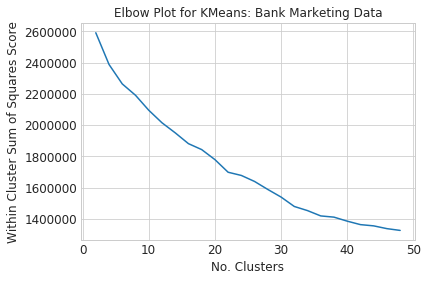

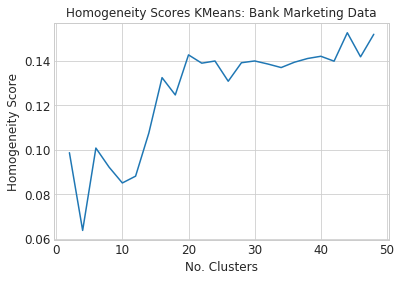

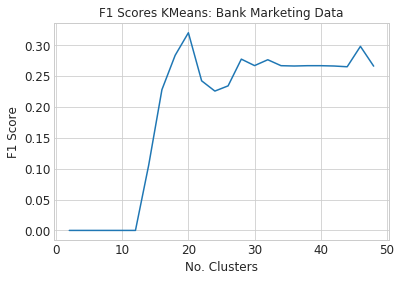

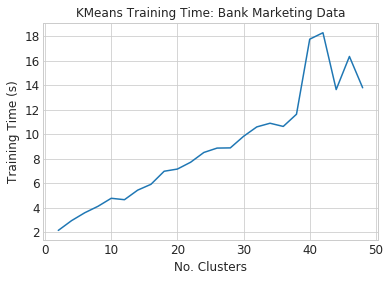

In [17]:
run_kmeans(bankX_scaled,bankY,'Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   7.31
No. Iterations to Converge: 24
F1 Score:  0.32
Accuracy:  0.90     AUC:       0.60
Precision: 0.60     Recall:    0.22
*****************************************************


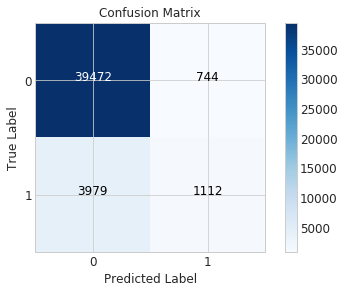

In [18]:
km = KMeans(n_clusters=20,n_init=10,random_state=100,n_jobs=-1)
evaluate_kmeans(km,bankX_scaled,bankY)

NMI score: 0.050801


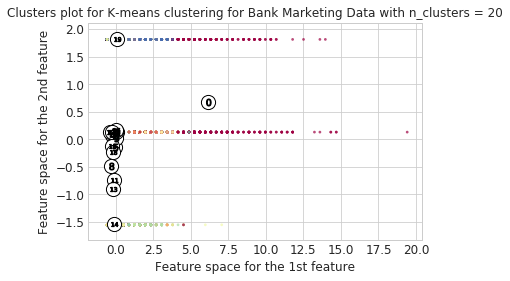

In [303]:
viz_clusters(bankX_scaled,bankY,[20],55,58,"Bank Marketing Data")

## Expectation Maximization

This section will implement k-means clustering for both datasets. The same 3 objectives from k-means apply here.

In [313]:
from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,50,2))
    log_likelihood = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        log_likelihood.append(em.score(X))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, log_likelihood)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Log Likelihood Of Gaussian Mixture')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores EM: '+ title)
    plt.show()

    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores EM: '+ title)
    plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

def viz_em(X_norm, y, range_n_clusters, f1, f2, title):
    X_norm = pd.DataFrame(X_norm)
    for n_clusters in range_n_clusters:
        fig = plt.gcf()
        #fig.set_size_inches(7, 7)
        ax = fig.add_subplot(111)

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_norm)
        cluster_labels = clusterer.predict(X_norm)
        #print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

        # 2nd Plot showing the actual clusters formed
        colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
        plt.scatter( X_norm.iloc[:, f1], X_norm.iloc[:, f2], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.means_

        # Draw white circles at cluster centers
        plt.scatter(centers[:, f1], centers[:, f2], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax.scatter( c[f1], c[f2], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax.set_title("Clusters plot for EM clustering on " + title + 
                      " with n_clusters = %d" % n_clusters)
        ax.set_xlabel("Feature space for the 1st feature")
        ax.set_ylabel("Feature space for the 2nd feature")

#         plt.suptitle(("Clusters plot for EM clustering on " 
#                       "with n_clusters = %d" % n_clusters),
#                      fontsize=14, fontweight='bold')

        plt.show()  

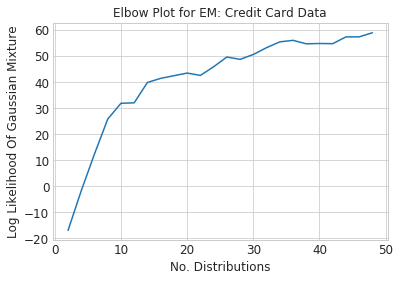

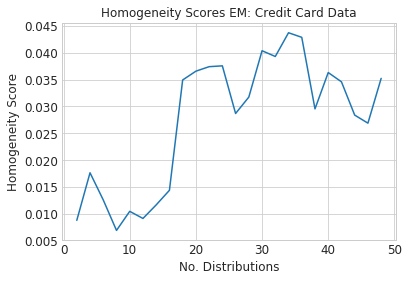

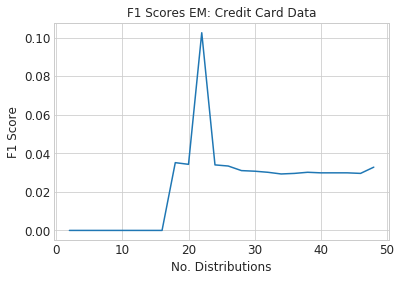

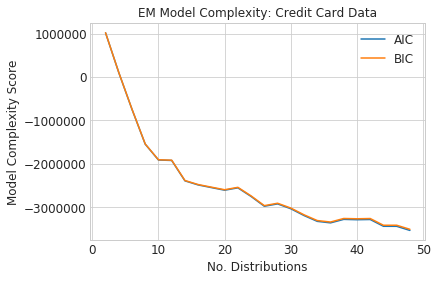

In [20]:
run_EM(ccX_scaled,ccY,'Credit Card Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   3.92
No. Iterations to Converge: 28
Log-likelihood Lower Bound: 42.60
F1 Score:  0.10
Accuracy:  0.78     AUC:       0.52
Precision: 0.58     Recall:    0.06
*****************************************************


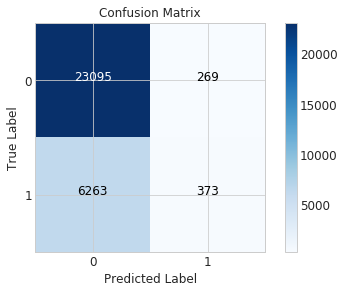

In [21]:
em = EM(n_components=22,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,ccX_scaled,ccY)

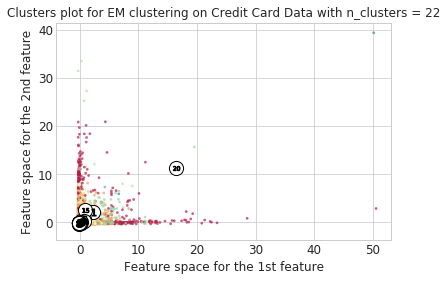

In [314]:
viz_em(ccX_scaled,ccY,[22],29,30, 'Credit Card Data')

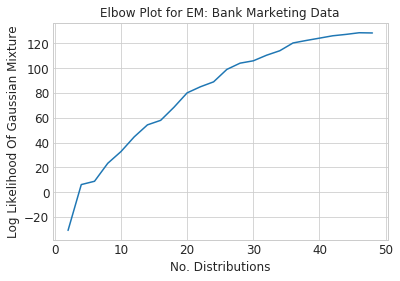

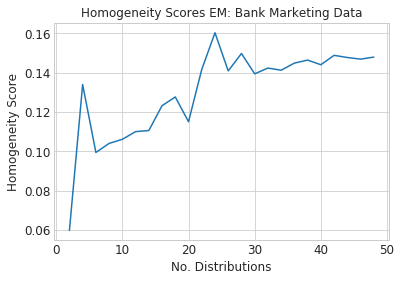

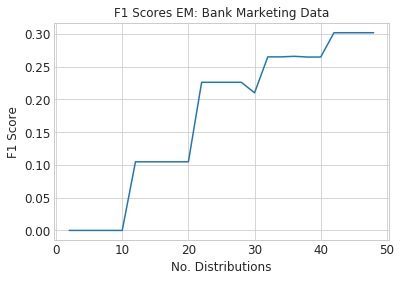

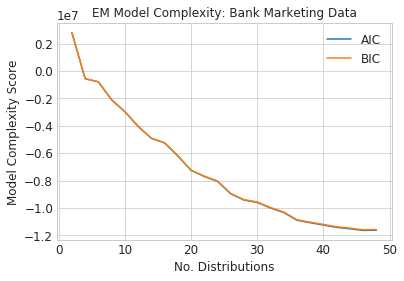

In [22]:
run_EM(bankX_scaled,bankY,'Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.34
No. Iterations to Converge: 8
Log-likelihood Lower Bound: 89.03
F1 Score:  0.23
Accuracy:  0.89     AUC:       0.56
Precision: 0.63     Recall:    0.14
*****************************************************


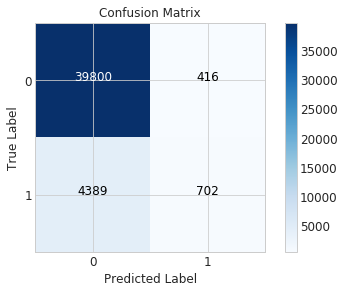

In [25]:
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,bankX_scaled,bankY)

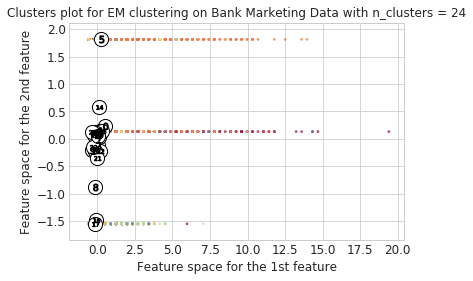

In [315]:
viz_em(bankX_scaled,bankY,[24],55,58, 'Bank Marketing Data')


# 4. Dimensionality Reduction

This section will implement 4 different dimensionality reduction techniques on both the credit card and the banking dataset. Then, k-means and EM clustering will be performed for each (dataset * dim_reduction) combination to see how the clustering compares with using the full datasets. The 4 dimensionality reduction techniques are:
- Principal Components Analysis (PCA). Optimal number of PC chosen by inspecting % variance explained and the eigenvalues.
- Independent Components Analysis (ICA). Optimal number of IC chosen by inspecting kurtosis.
- Random Components Analysis (RCA) (otherwise known as Randomized Projections). Optimal number of RC chosen by inspecting reconstruction error.
- Random Forest Classifier (RFC). Optimal number of components chosen by feature importance.

In [257]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X,y,title):
    
    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    #d = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']
    #dims = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    ica = ICA(random_state=5, tol = 0.3)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_RCA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),6))
    dims.append(X.shape[1])
    tmp = defaultdict(dict)

    for i,dim in product(range(5),dims):
        rp = RCA(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
        #rp = RCA(random_state=1, n_components=2)
        #X_t = rp.fit_transform(ccX_scaled)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()
    
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=.01,random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[2::])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols



    
def run_rca_kmeans(X,y,title,k):

    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    kurt = []
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; wcss = []; accuracy = []; 

    for dim in dims:
        tmp = []
        for i in range(3):
            rp = RCA(random_state=i, n_components=dim).fit_transform(X)
            km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(rp)
            y_mode_vote = cluster_predictions(y,km.labels_)
            tmp.append(f1_score(y, y_mode_vote))
        f1_scores.append(sum(tmp)/len(tmp))      


    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dims, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Independent Components')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores KMeans: '+ title)
    plt.show()
    
    
def run_rca_em(X,y,title,k):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    kurt = []
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; wcss = []; accuracy = [];
        
    for dim in dims:
        tmp = []
        for i in range(3):
            rp = RCA(random_state=i, n_components=dim).fit_transform(X)
            em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(rp)
            labels = em.predict(rp)
            y_mode_vote = cluster_predictions(y,labels)
            tmp.append(f1_score(y, y_mode_vote))
        f1_scores.append(sum(tmp)/len(tmp))      
        

    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dims, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Independent Components')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores KMeans: '+ title)
    plt.show()


def viz_data(X_comp, X, y, title):
    X_r = X_comp.transform(X)
    
    print('explained variance ratio (first two components): %s'
          % str(X_comp.explained_variance_ratio_[:2]))

    plt.figure()
    colors = ["b","g","r","c","m","y","k"]
    lw = 2

    for color, i in zip(colors, [0,1]):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    
def viz_data_ica(X_comp, X, y, title):
    X_r = X_comp.transform(X)
    
    plt.figure()
    colors = ["b","g","r","c","m","y","k"]
    lw = 2

    for color, i in zip(colors, [0,1]):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)

### PCA

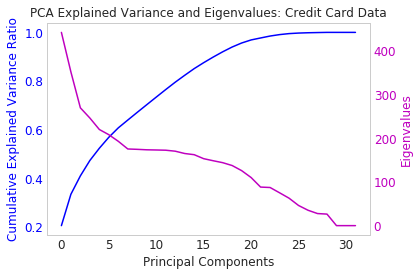

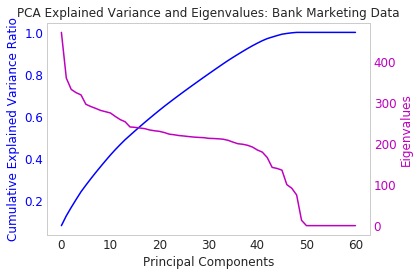

In [28]:
run_PCA(ccX_scaled,ccY,"Credit Card Data")
run_PCA(bankX_scaled,bankY,"Bank Marketing Data")

In [316]:
pca_cc = PCA(n_components=15,random_state=5).fit_transform(ccX_scaled)
pca_bank = PCA(n_components=30,random_state=5).fit_transform(bankX_scaled)
pc_cc = PCA(n_components=15, random_state=10).fit(ccX_scaled)
pc_bank = PCA(n_components=30,random_state=5).fit(bankX_scaled)

explained variance ratio (first two components): [0.2040695  0.12915043]
explained variance ratio (first two components): [0.08931235 0.04708174]


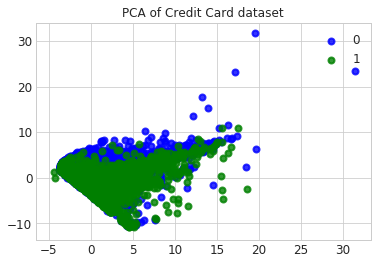

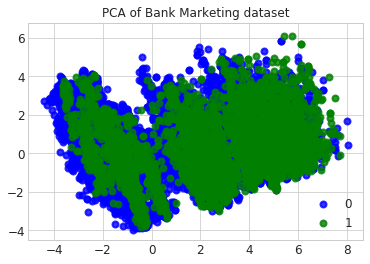

In [152]:
viz_data(pc_cc, ccX_scaled, ccY, 'PCA of Credit Card dataset')
viz_data(pc_bank, bankX_scaled, bankY, 'PCA of Bank Marketing dataset')

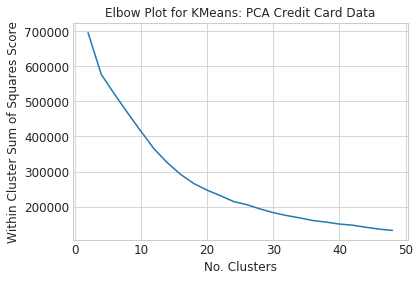

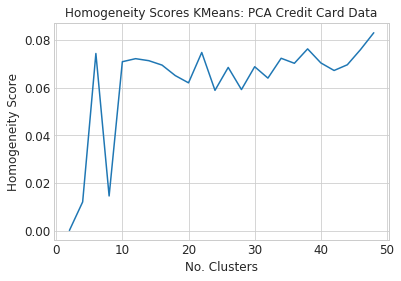

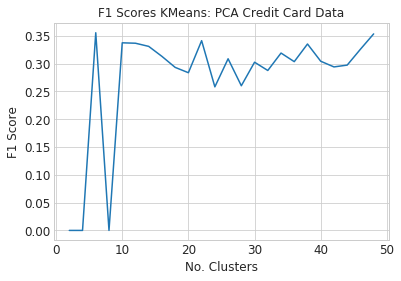

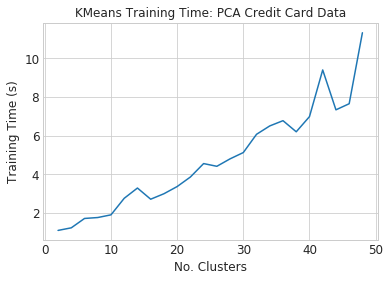

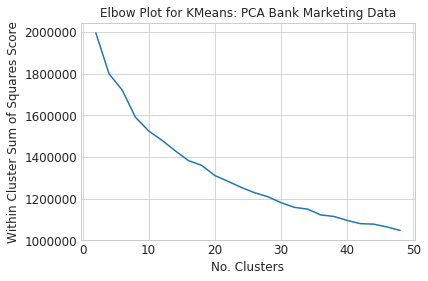

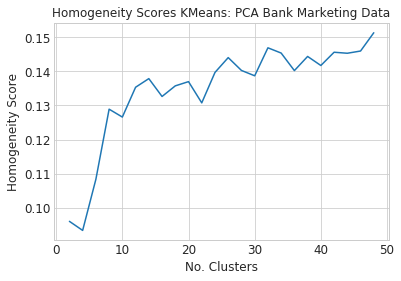

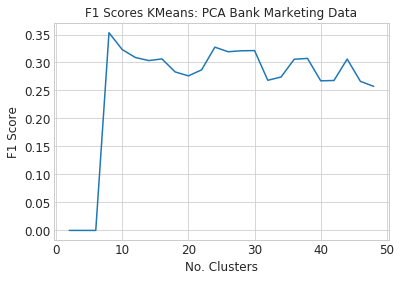

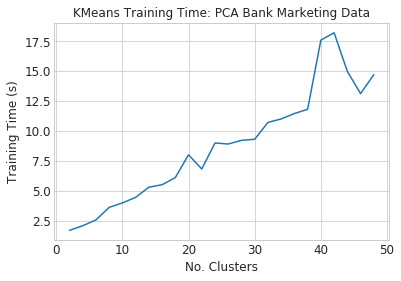

In [30]:
run_kmeans(pca_cc,ccY,'PCA Credit Card Data')
run_kmeans(pca_bank,bankY,'PCA Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.83
No. Iterations to Converge: 23
F1 Score:  0.36
Accuracy:  0.80     AUC:       0.60
Precision: 0.64     Recall:    0.25
*****************************************************


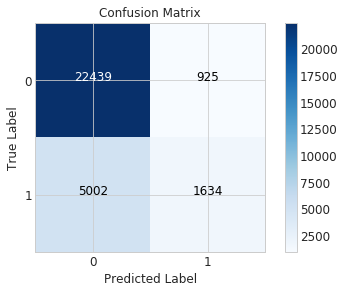

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   3.52
No. Iterations to Converge: 12
F1 Score:  0.35
Accuracy:  0.89     AUC:       0.62
Precision: 0.53     Recall:    0.27
*****************************************************


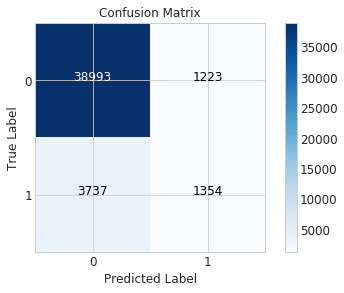

In [31]:
evaluate_kmeans(KMeans(n_clusters=6,n_init=10,random_state=100,n_jobs=-1),pca_cc,ccY)
evaluate_kmeans(KMeans(n_clusters=8,n_init=10,random_state=100,n_jobs=-1),pca_bank,bankY)

NMI score: 0.043588


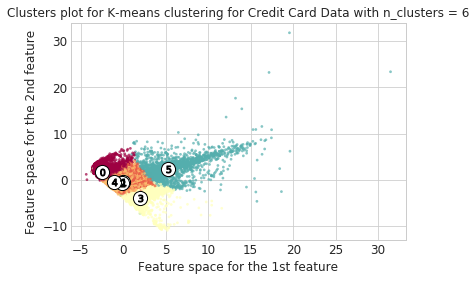

NMI score: 0.056188


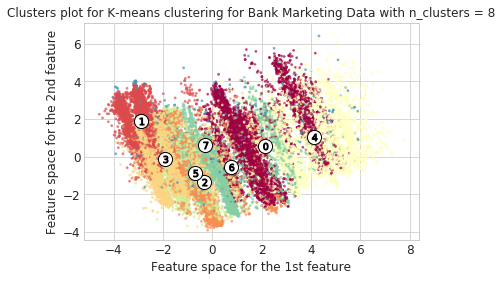

In [320]:
viz_clusters(pca_cc,ccY,[6],0,1,'Credit Card Data')
viz_clusters(pca_bank,bankY,[8],0,1,'Bank Marketing Data')

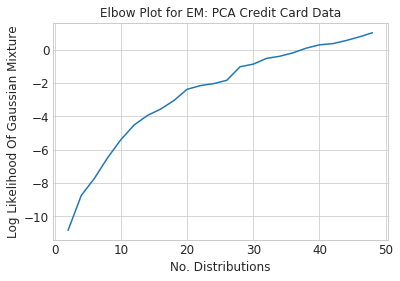

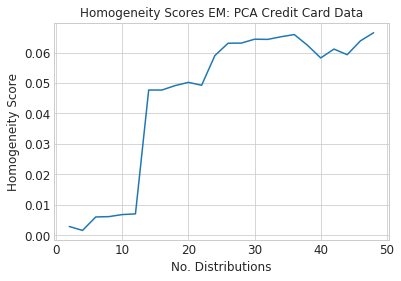

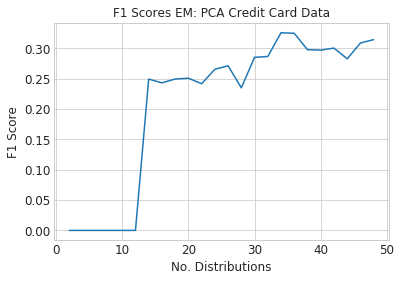

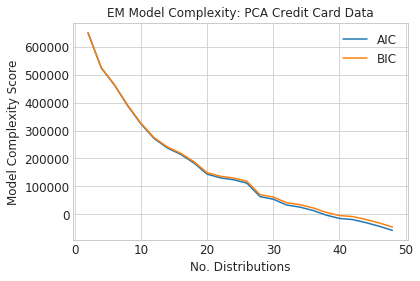

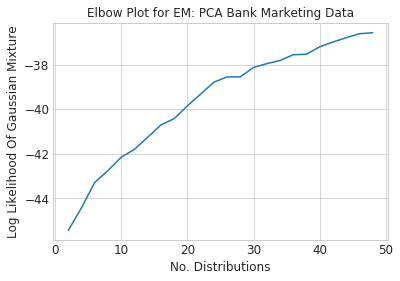

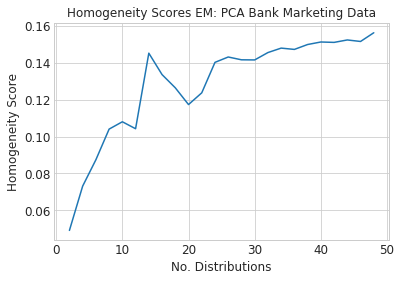

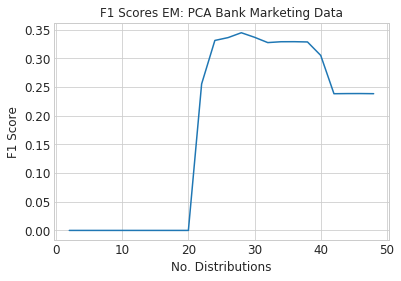

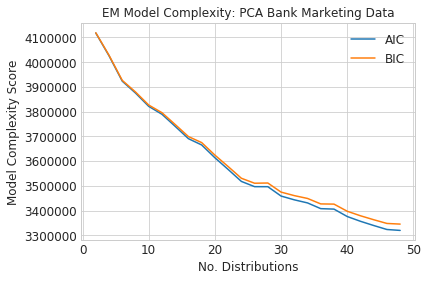

In [32]:
run_EM(pca_cc,ccY,'PCA Credit Card Data')
run_EM(pca_bank,bankY,'PCA Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.38
No. Iterations to Converge: 12
Log-likelihood Lower Bound: -3.94
F1 Score:  0.25
Accuracy:  0.79     AUC:       0.56
Precision: 0.61     Recall:    0.16
*****************************************************


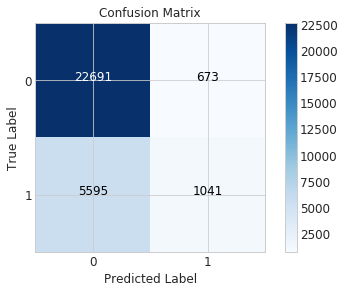

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   6.22
No. Iterations to Converge: 23
Log-likelihood Lower Bound: -38.55
F1 Score:  0.34
Accuracy:  0.89     AUC:       0.61
Precision: 0.53     Recall:    0.26
*****************************************************


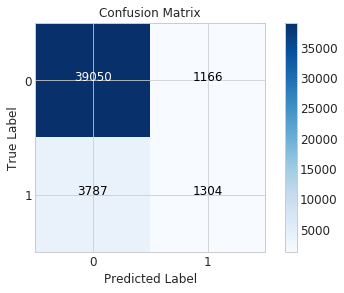

In [33]:
evaluate_EM(EM(n_components=14,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_cc,ccY)
evaluate_EM(EM(n_components=28,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_bank,bankY)

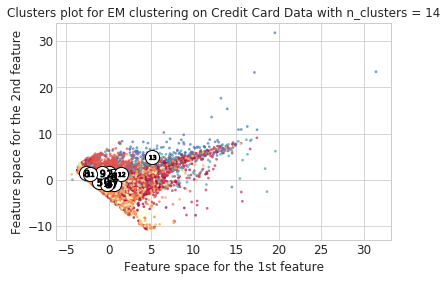

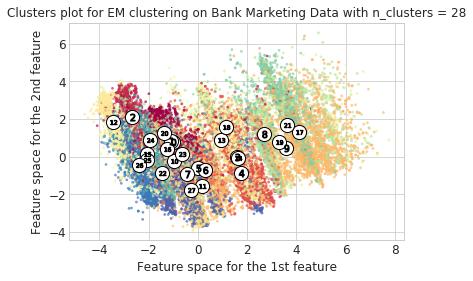

In [322]:
viz_em(pca_cc,ccY,[14],0,1, 'Credit Card Data')
viz_em(pca_bank,bankY,[28],0,1, 'Bank Marketing Data')

## ICA

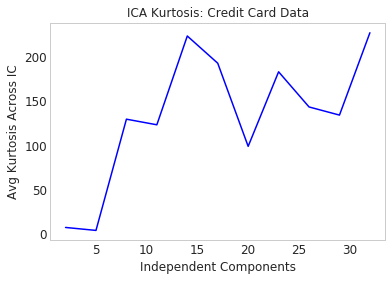

/home/ravi/miniconda2/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


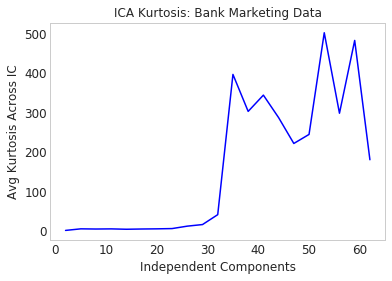

In [163]:
run_ICA(ccX_scaled,ccY,"Credit Card Data")
run_ICA(bankX_scaled,bankY,"Bank Marketing Data")

In [205]:
ica_cc = ICA(n_components=14,random_state=5).fit_transform(ccX_scaled)
ica_bank = ICA(n_components=53,random_state=5).fit_transform(bankX_scaled)
ic_cc = ICA(n_components=14, random_state=10).fit(ccX_scaled)
ic_bank = ICA(n_components=53,random_state=5).fit(bankX_scaled)

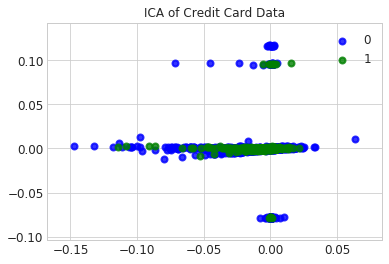

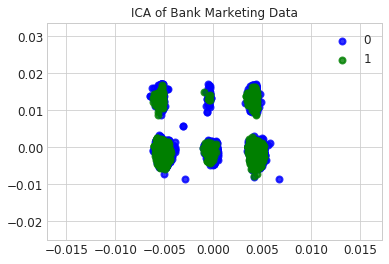

In [207]:
viz_data_ica(ic_cc, ccX_scaled, ccY, 'ICA of Credit Card Data')
viz_data_ica(ic_bank, bankX_scaled, bankY, 'ICA of Bank Marketing Data')

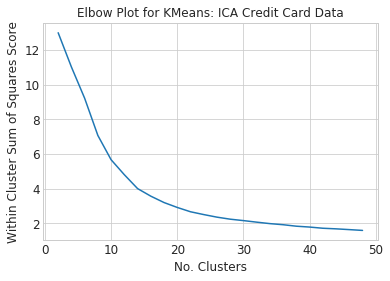

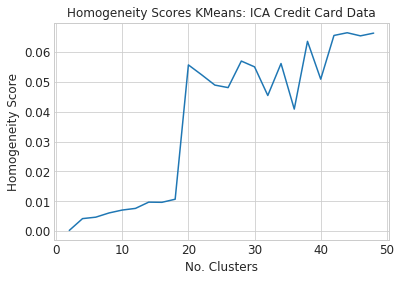

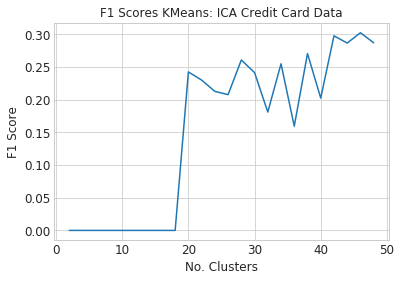

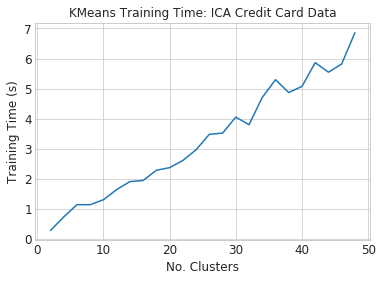

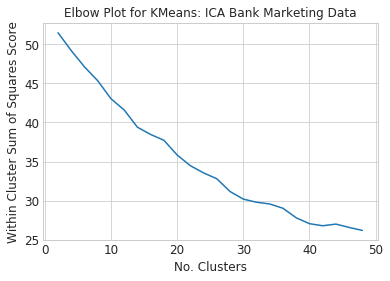

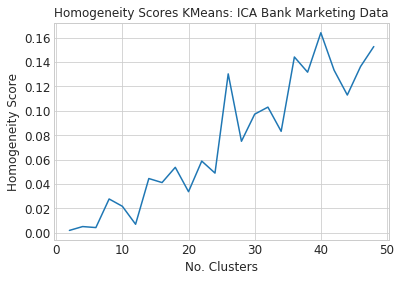

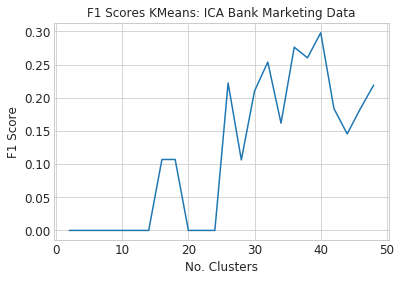

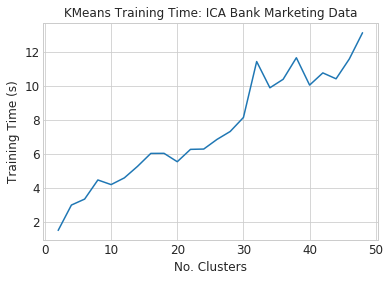

In [210]:
run_kmeans(ica_cc,ccY,'ICA Credit Card Data')
run_kmeans(ica_bank,bankY,'ICA Bank Marketing Data')

In [219]:
# tmp = pd.DataFrame(ica_cc).kurt(axis=0)
# tm = [i for i in tmp]
# f1 = tm.index(sorted(tm, reverse = True)[0])
# f2 = tm.index(sorted(tm, reverse = True)[1])

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.49
No. Iterations to Converge: 18
F1 Score:  0.24
Accuracy:  0.80     AUC:       0.56
Precision: 0.67     Recall:    0.15
*****************************************************


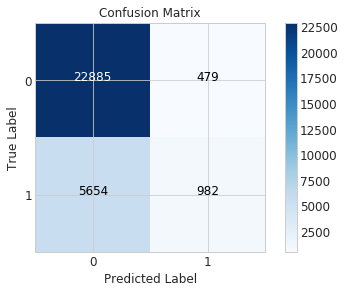

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   10.74
No. Iterations to Converge: 14
F1 Score:  0.30
Accuracy:  0.89     AUC:       0.59
Precision: 0.53     Recall:    0.21
*****************************************************


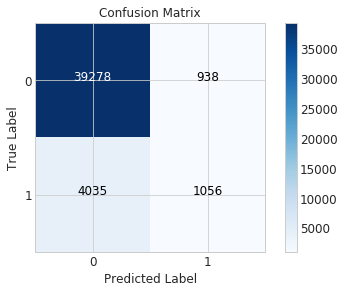

In [220]:
evaluate_kmeans(KMeans(n_clusters=20,n_init=10,random_state=100,n_jobs=-1),ica_cc,ccY)
evaluate_kmeans(KMeans(n_clusters=40,n_init=10,random_state=100,n_jobs=-1),ica_bank,bankY)

NMI score: 0.025001


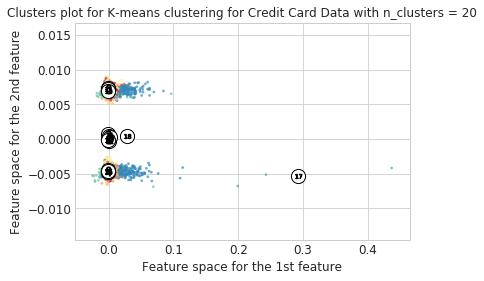

NMI score: 0.044730


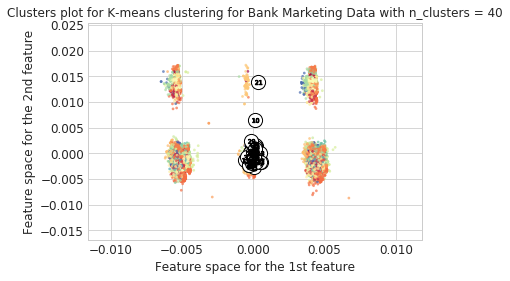

In [324]:
viz_clusters(ica_cc,ccY,[20],0,1,'Credit Card Data')
viz_clusters(ica_bank,bankY,[40],0,1,'Bank Marketing Data')

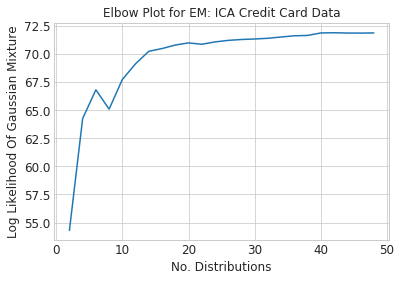

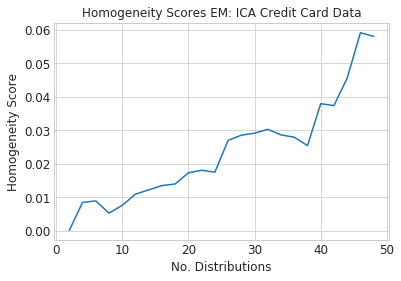

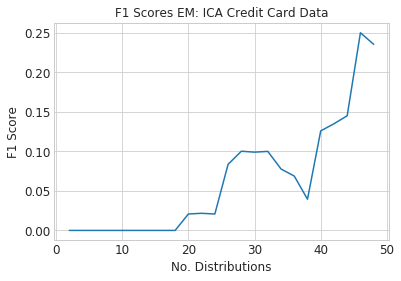

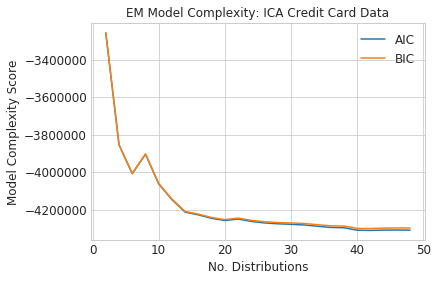

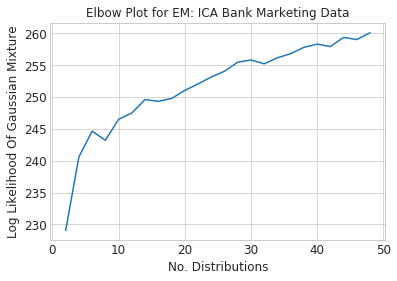

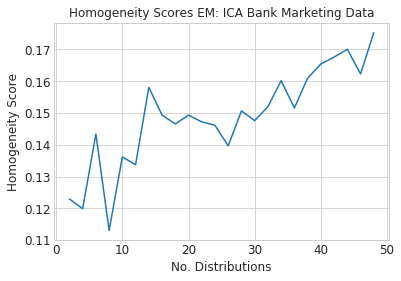

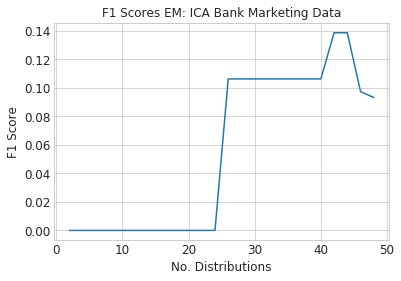

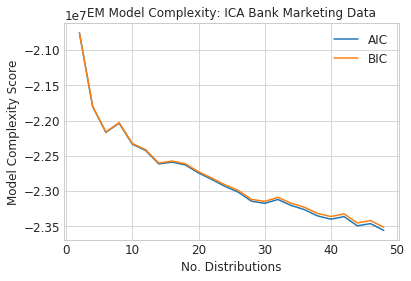

In [222]:
run_EM(ica_cc,ccY,'ICA Credit Card Data')
run_EM(ica_bank,bankY,'ICA Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   1.38
No. Iterations to Converge: 11
Log-likelihood Lower Bound: 70.99
F1 Score:  0.02
Accuracy:  0.78     AUC:       0.50
Precision: 0.74     Recall:    0.01
*****************************************************


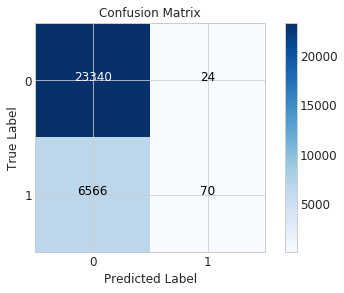

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   6.34
No. Iterations to Converge: 25
Log-likelihood Lower Bound: 254.05
F1 Score:  0.11
Accuracy:  0.89     AUC:       0.53
Precision: 0.51     Recall:    0.06
*****************************************************


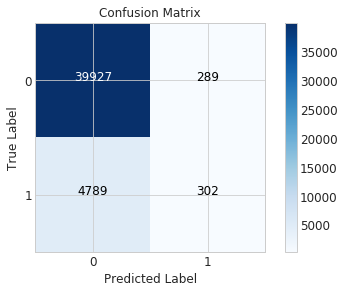

In [229]:
evaluate_EM(EM(n_components=20,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_cc,ccY)
evaluate_EM(EM(n_components=26,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_bank,bankY)

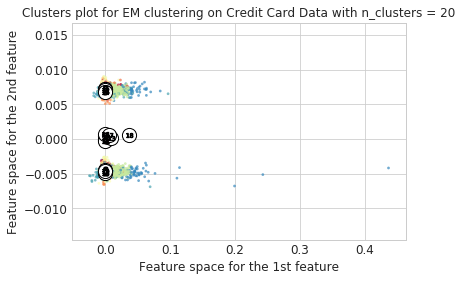

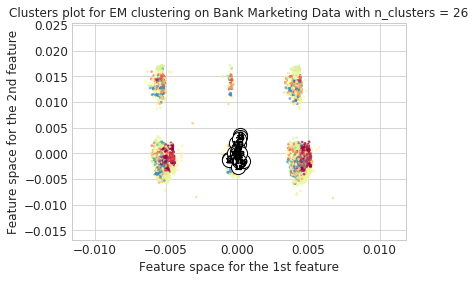

In [325]:
viz_em(ica_cc,ccY,[20],0,1,'Credit Card Data')
viz_em(ica_bank,bankY,[26],0,1,'Bank Marketing Data')

### RCA

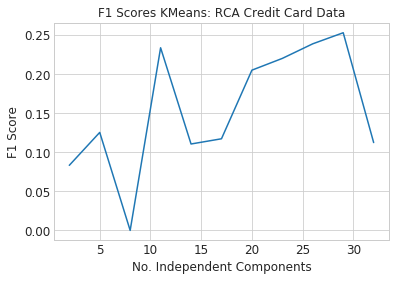

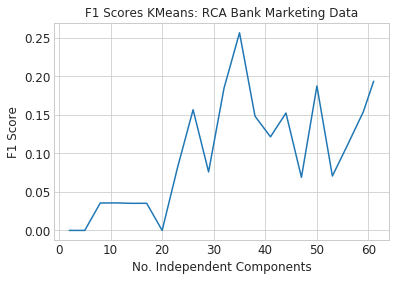

In [52]:
run_rca_kmeans(ccX_scaled,ccY,'RCA Credit Card Data',8)
run_rca_kmeans(bankX_scaled,bankY,'RCA Bank Marketing Data',20)

In [231]:
rca_cc = RCA(n_components=11,random_state=5).fit_transform(ccX_scaled)
rca_bank = RCA(n_components=35,random_state=5).fit_transform(bankX_scaled)
rc_cc = RCA(n_components=11, random_state=5).fit(ccX_scaled)
rc_bank = RCA(n_components=35,random_state=5).fit(bankX_scaled)

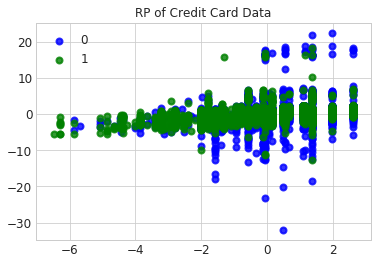

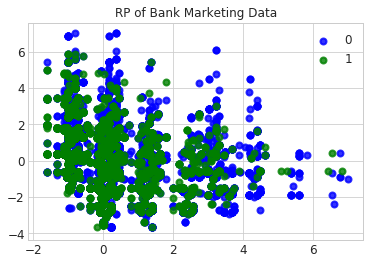

In [232]:
viz_data_ica(rc_cc, ccX_scaled, ccY, 'RP of Credit Card Data')
viz_data_ica(rc_bank, bankX_scaled, bankY, 'RP of Bank Marketing Data')

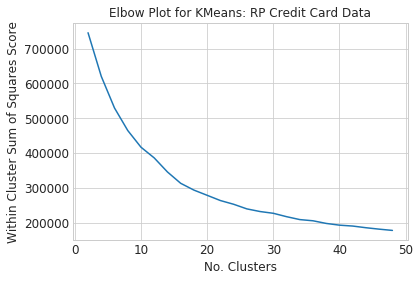

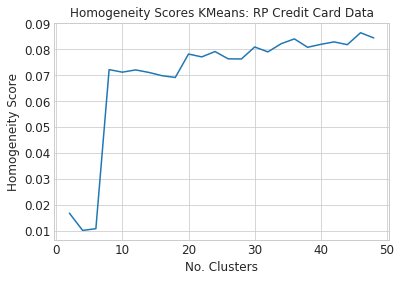

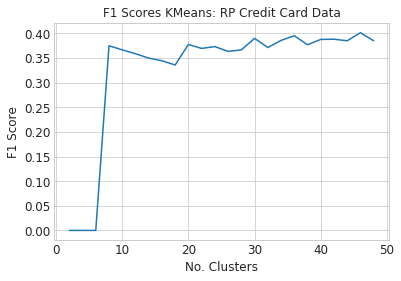

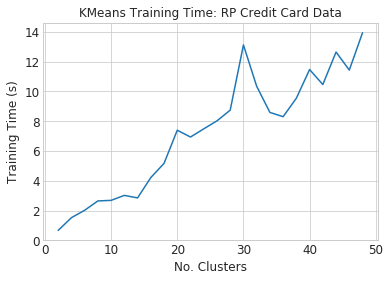

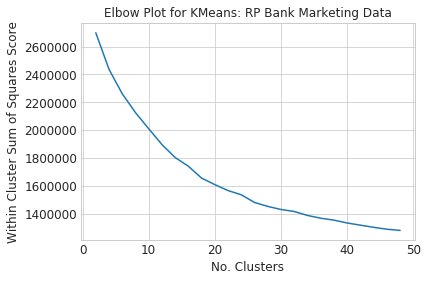

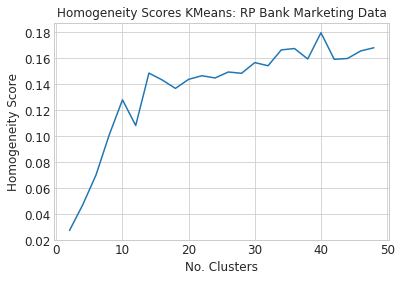

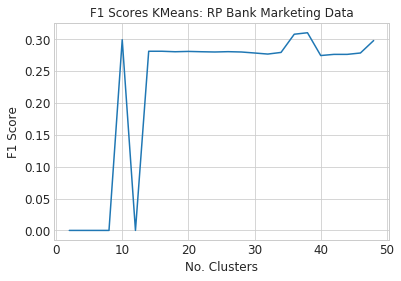

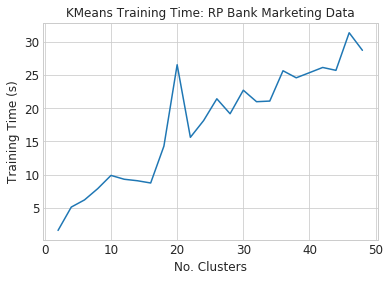

In [56]:
run_kmeans(rca_cc,ccY,'RP Credit Card Data')
run_kmeans(rca_bank,bankY,'RP Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.45
No. Iterations to Converge: 59
F1 Score:  0.37
Accuracy:  0.80     AUC:       0.61
Precision: 0.58     Recall:    0.28
*****************************************************


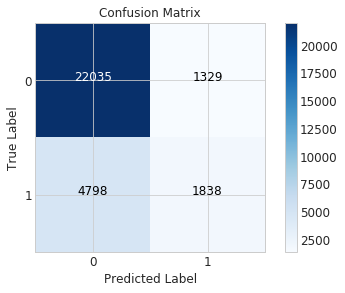

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   8.85
No. Iterations to Converge: 104
F1 Score:  0.30
Accuracy:  0.89     AUC:       0.59
Precision: 0.52     Recall:    0.21
*****************************************************


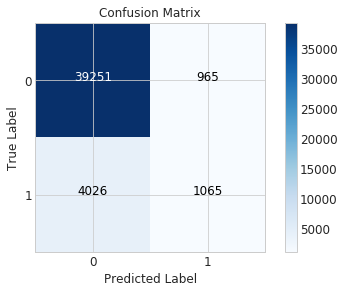

In [57]:
evaluate_kmeans(KMeans(n_clusters=8,n_init=10,random_state=100,n_jobs=-1),rca_cc,ccY)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100,n_jobs=-1),rca_bank,bankY)

NMI score: 0.042685


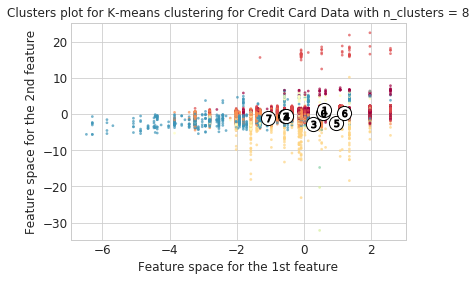

NMI score: 0.049374


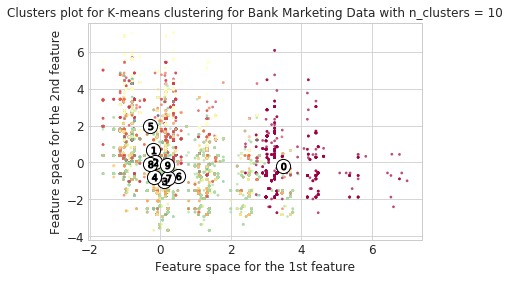

In [326]:
viz_clusters(rca_cc,ccY,[8],0,1,'Credit Card Data')
viz_clusters(rca_bank,bankY,[10],0,1,'Bank Marketing Data')

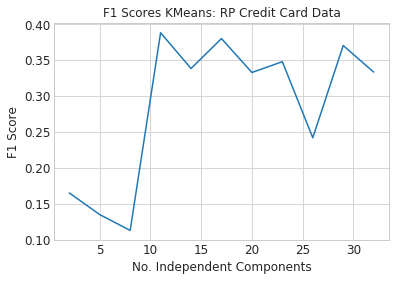

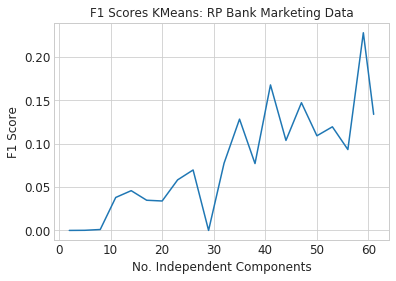

In [58]:
run_rca_em(ccX_scaled,ccY,'RP Credit Card Data',22)
run_rca_em(bankX_scaled,bankY,'RP Bank Marketing Data',24)

In [234]:
rca_cc_em = RCA(n_components=11,random_state=5).fit_transform(ccX_scaled)
rca_bank_em = RCA(n_components=41,random_state=5).fit_transform(bankX_scaled)
rc_cc_em = RCA(n_components=11,random_state=5).fit(ccX_scaled)
rc_bank_em = RCA(n_components=41,random_state=5).fit(bankX_scaled)

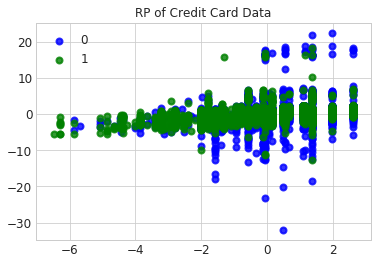

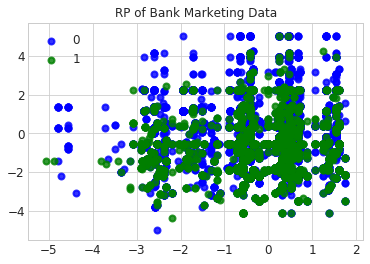

In [235]:
viz_data_ica(rc_cc_em, ccX_scaled, ccY, 'RP of Credit Card Data')
viz_data_ica(rc_bank_em, bankX_scaled, bankY, 'RP of Bank Marketing Data')

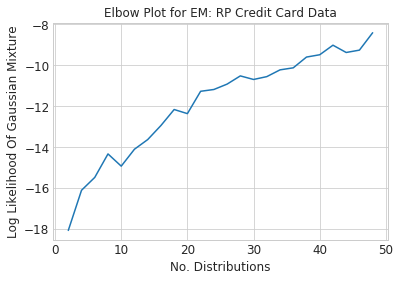

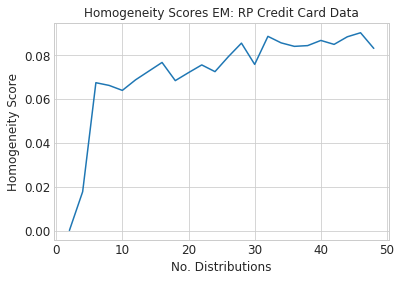

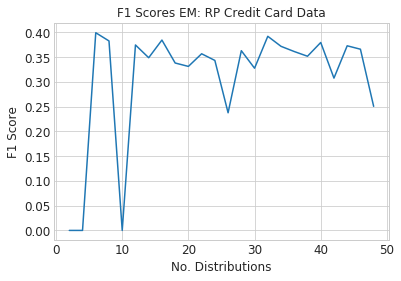

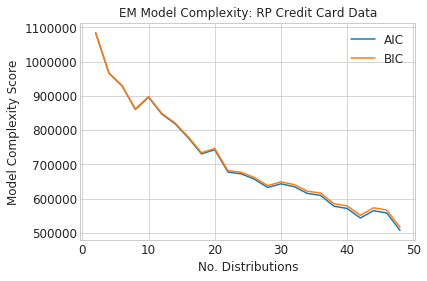

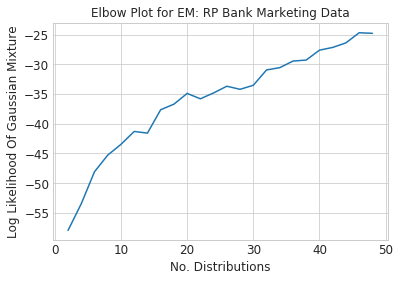

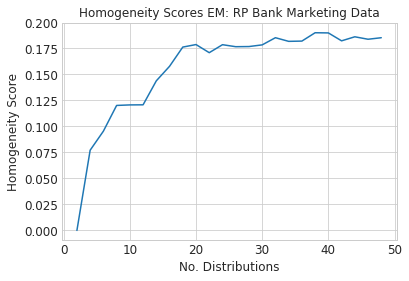

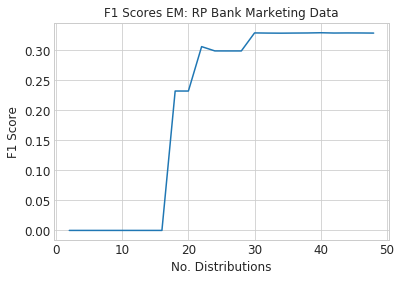

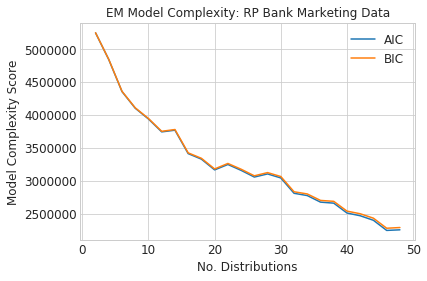

In [61]:
run_EM(rca_cc,ccY,'RP Credit Card Data')
run_EM(rca_bank,bankY,'RP Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.92
No. Iterations to Converge: 52
Log-likelihood Lower Bound: -15.48
F1 Score:  0.40
Accuracy:  0.78     AUC:       0.62
Precision: 0.50     Recall:    0.33
*****************************************************


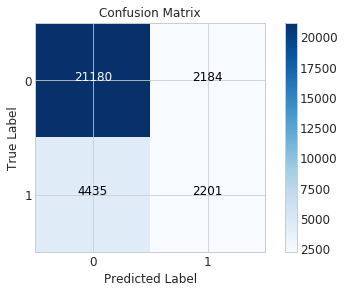

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   8.94
No. Iterations to Converge: 29
Log-likelihood Lower Bound: -35.80
F1 Score:  0.31
Accuracy:  0.89     AUC:       0.59
Precision: 0.59     Recall:    0.21
*****************************************************


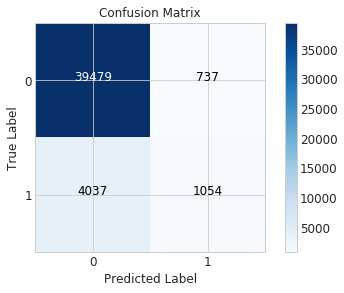

In [62]:
evaluate_EM(EM(n_components=6,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_cc,ccY)
evaluate_EM(EM(n_components=22,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_bank,bankY)

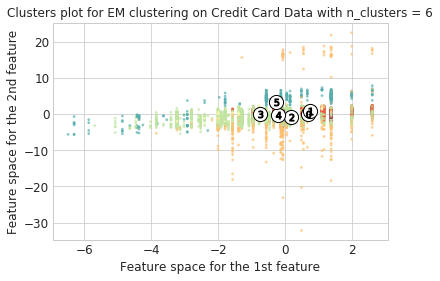

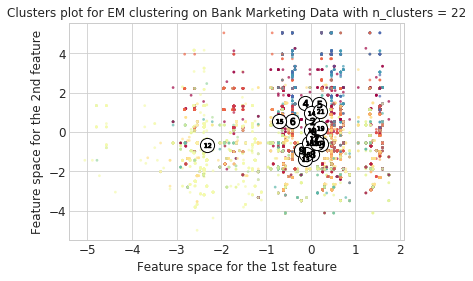

In [328]:
viz_em(rca_cc_em,ccY,[6],0,1,'Credit Card Data')
viz_em(rca_bank_em,bankY,[22],0,1,'Bank Marketing Data')

### Random Forest Classifier

In [249]:
imp_cc, topcols_cc = run_RFC(ccX_scaled,ccY,df_cc)
imp_bank, topcols_bank = run_RFC(bankX_scaled,bankY,df_bank)

In [251]:
rfc_cc = df_cc[topcols_cc]
rfc_cc = np.array(rfc_cc.values,dtype='int64')
scaler = StandardScaler().fit(rfc_cc)
rfc_cc = scaler.transform(rfc_cc)
rfc_bank = df_bank[topcols_bank]
rfc_bank = np.array(rfc_bank.values,dtype='int64')
scaler = StandardScaler().fit(rfc_bank)
rfc_bank = scaler.transform(rfc_bank)

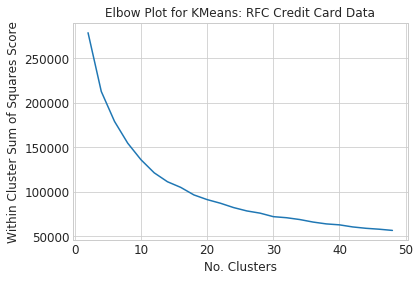

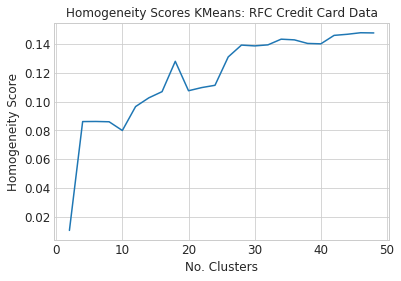

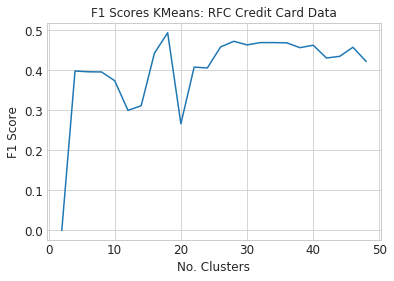

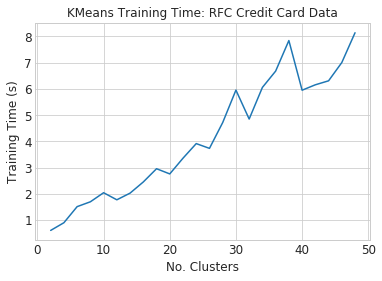

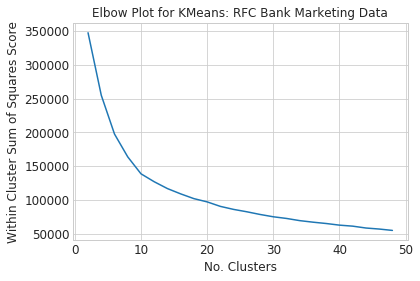

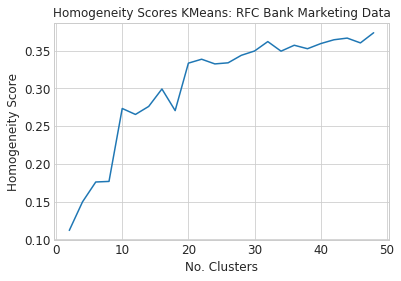

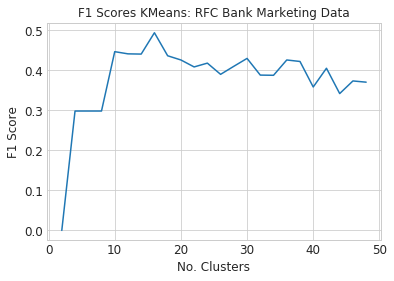

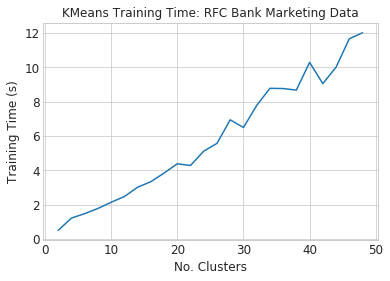

In [70]:
run_kmeans(rfc_cc,ccY,'RFC Credit Card Data')
run_kmeans(rfc_bank,bankY,'RFC Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   3.15
No. Iterations to Converge: 34
F1 Score:  0.49
Accuracy:  0.81     AUC:       0.67
Precision: 0.58     Recall:    0.43
*****************************************************


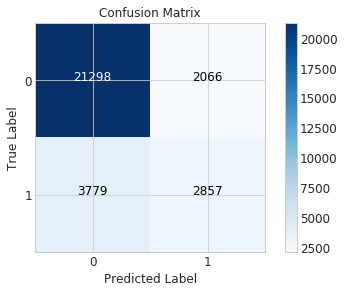

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   2.24
No. Iterations to Converge: 13
F1 Score:  0.45
Accuracy:  0.90     AUC:       0.66
Precision: 0.59     Recall:    0.36
*****************************************************


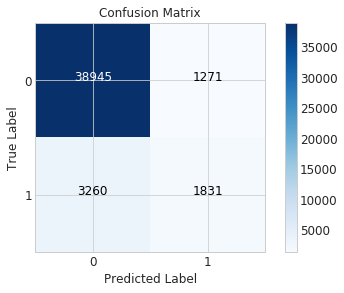

In [71]:
evaluate_kmeans(KMeans(n_clusters=18,n_init=10,random_state=100,n_jobs=-1),rfc_cc,ccY)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100,n_jobs=-1),rfc_bank,bankY)

NMI score: 0.059467


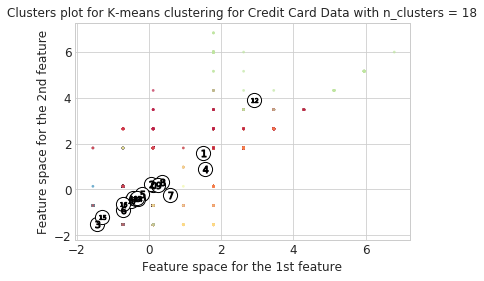

NMI score: 0.117137


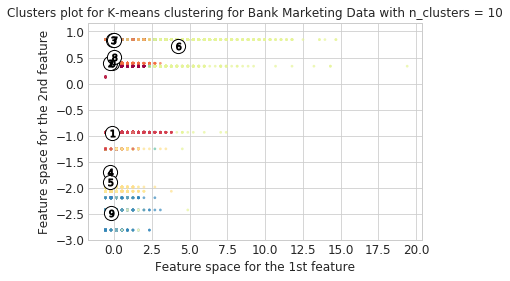

In [340]:
viz_clusters(rfc_cc,ccY,[18],0,1,'Credit Card Data')
viz_clusters(rfc_bank,bankY,[10],0,1,'Bank Marketing Data')

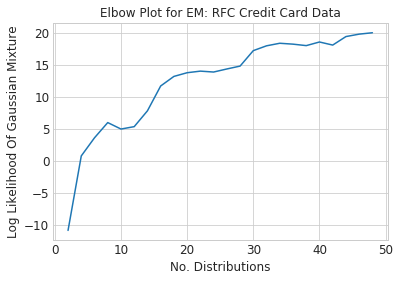

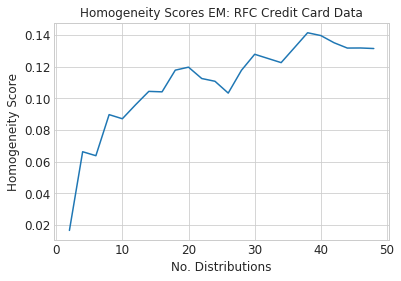

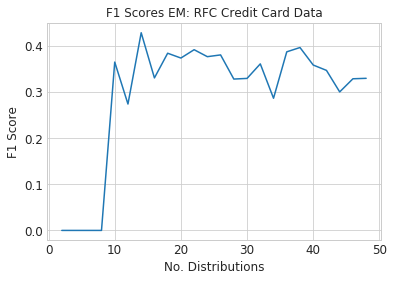

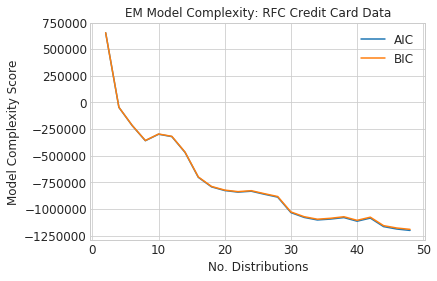

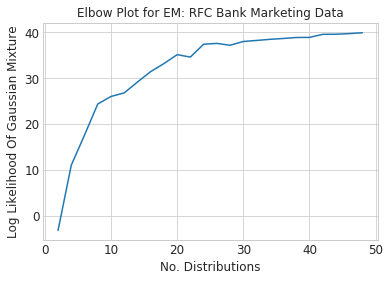

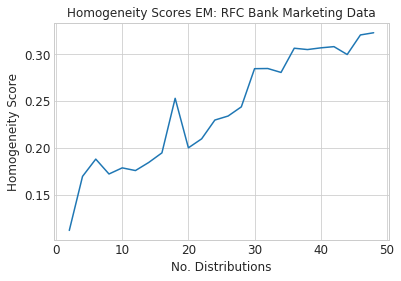

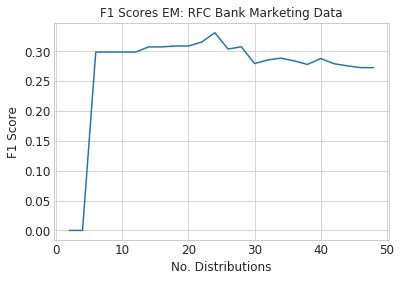

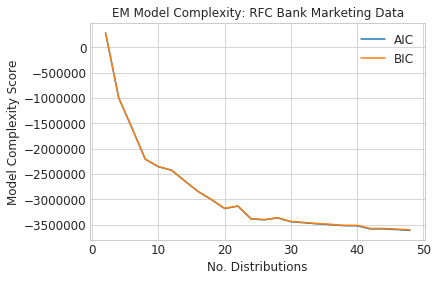

In [72]:
run_EM(rfc_cc,ccY,'RFC Credit Card Data')
run_EM(rfc_bank,bankY,'RFC Bank Marketing Data')

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   5.03
No. Iterations to Converge: 63
Log-likelihood Lower Bound: 7.84
F1 Score:  0.43
Accuracy:  0.80     AUC:       0.63
Precision: 0.57     Recall:    0.34
*****************************************************


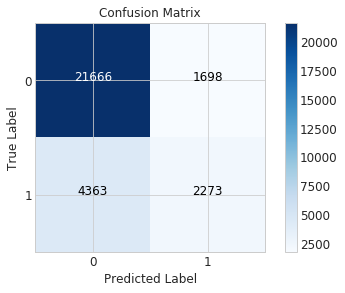

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.76
No. Iterations to Converge: 6
Log-likelihood Lower Bound: 24.36
F1 Score:  0.30
Accuracy:  0.90     AUC:       0.59
Precision: 0.65     Recall:    0.19
*****************************************************


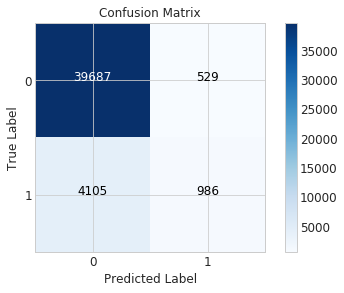

In [73]:
evaluate_EM(EM(n_components=14,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_cc,ccY)
evaluate_EM(EM(n_components=8,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_bank,bankY)

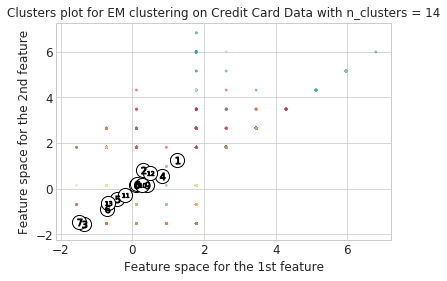

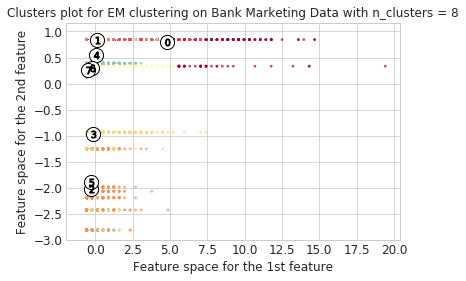

In [341]:
viz_em(rfc_cc,ccY,[14],0,1,'Credit Card Data')
viz_em(rfc_bank,bankY,[8],0,1,'Bank Marketing Data')

# 5. Training Neural Network on Projected Data

This section will train a neural network on the 4 projected datasets for only the Bank Marketing data. We will examine the learning curves on the training data as well as the final network performance on the test dataset.

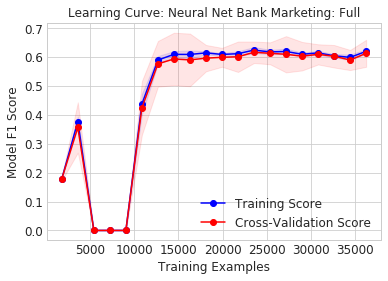

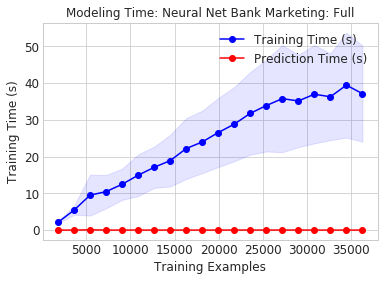

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   20.18510
Model Prediction Time (s): 0.01384

F1 Score:  0.60
Accuracy:  0.91     AUC:       0.77
Precision: 0.60     Recall:    0.59
*****************************************************


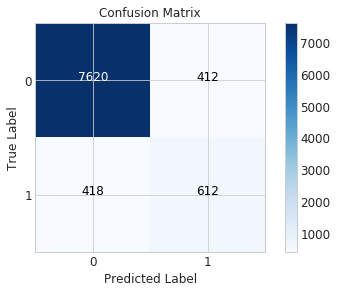

In [75]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(bankX),np.array(bankY), test_size=0.20, random_state =33)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

full_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train_scaled, y_train,title="Neural Net Bank Marketing: Full")
final_classifier_evaluation(full_est, X_train_scaled, X_test_scaled, y_train, y_test)

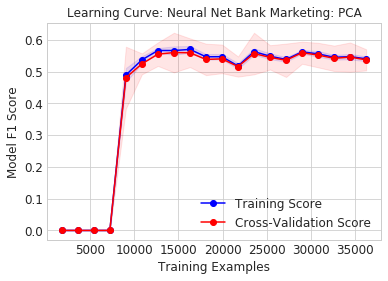

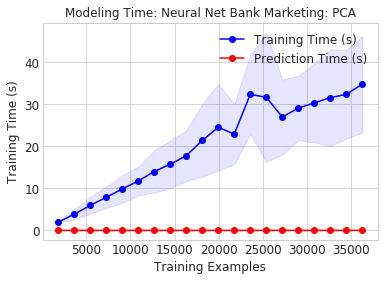

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   19.46503
F1 Score:  0.53
Accuracy:  0.90     AUC:       0.72
Precision: 0.57     Recall:    0.49
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00760

F1 Score:  0.51
Accuracy:  0.90     AUC:       0.71
Precision: 0.56     Recall:    0.47
*****************************************************


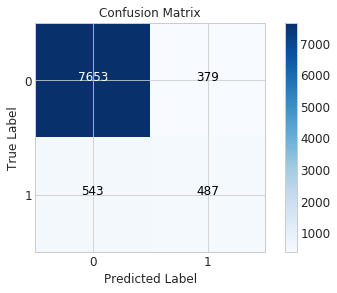

In [80]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca_bank),np.array(bankY), test_size=0.20, random_state =3)
pca_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Bank Marketing: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

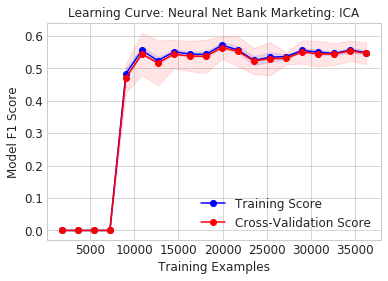

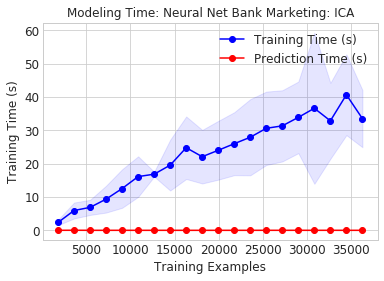

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   18.78543
F1 Score:  0.54
Accuracy:  0.90     AUC:       0.73
Precision: 0.57     Recall:    0.50
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.02727

F1 Score:  0.52
Accuracy:  0.90     AUC:       0.72
Precision: 0.56     Recall:    0.48
*****************************************************


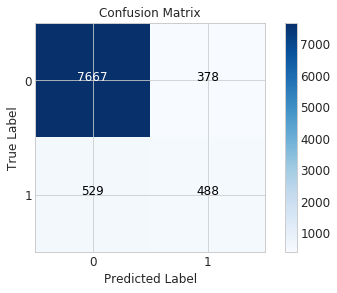

In [123]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica_bank),np.array(bankY), test_size=0.20, random_state =3)
ica_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Bank Marketing: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

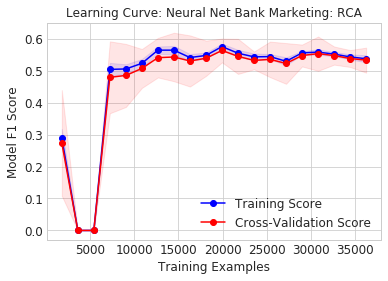

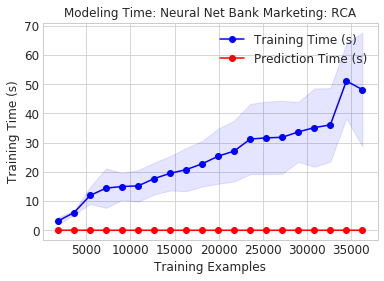

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   21.11137
F1 Score:  0.54
Accuracy:  0.91     AUC:       0.73
Precision: 0.61     Recall:    0.49
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.01219

F1 Score:  0.54
Accuracy:  0.91     AUC:       0.72
Precision: 0.61     Recall:    0.49
*****************************************************


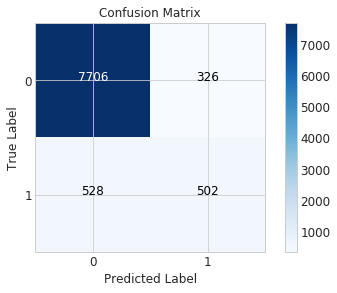

In [82]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rca_bank),np.array(bankY), test_size=0.20, random_state =3)
rca_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Bank Marketing: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)

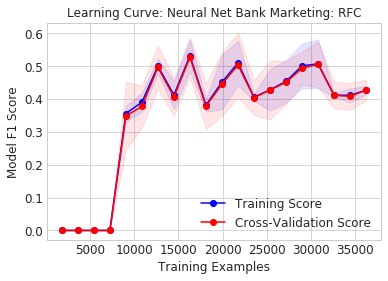

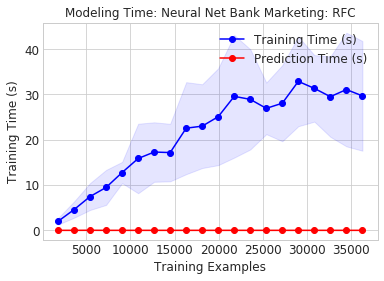

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   15.65981
F1 Score:  0.40
Accuracy:  0.90     AUC:       0.64
Precision: 0.57     Recall:    0.31
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00660

F1 Score:  0.40
Accuracy:  0.90     AUC:       0.64
Precision: 0.59     Recall:    0.30
*****************************************************


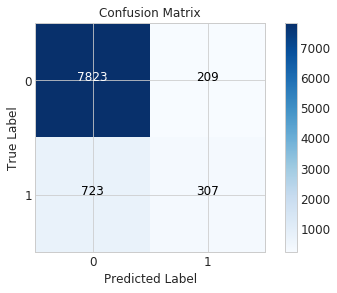

In [124]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rfc_bank),np.array(bankY), test_size=0.20, random_state =3)
rfc_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Bank Marketing: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

# 6. Model Comparison Plots

Let's define and call a function that will plot training times and learning rates for the 4 different NN models so that we can compare across the classifiers for the same dataset.

In [125]:
def compare_fit_time(n,full_fit,pca_fit,ica_fit,rca_fit,rfc_fit,title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, full_fit, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_fit, '-', color="b", label="PCA")
    plt.plot(n, ica_fit, '-', color="r", label="ICA")
    plt.plot(n, rca_fit, '-', color="g", label="RCA")
    plt.plot(n, rfc_fit, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,full_pred, pca_pred, ica_pred, rca_pred, rfc_pred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, full_pred, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_pred, '-', color="b", label="PCA")
    plt.plot(n, ica_pred, '-', color="r", label="ICA")
    plt.plot(n, rca_pred, '-', color="g", label="RCA")
    plt.plot(n, rfc_pred, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,full_learn, pca_learn, ica_learn, rca_learn, rfc_learn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, full_learn, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_learn, '-', color="b", label="PCA")
    plt.plot(n, ica_learn, '-', color="r", label="ICA")
    plt.plot(n, rca_learn, '-', color="g", label="RCA")
    plt.plot(n, rfc_learn, '-', color="m", label="RFC")
    plt.legend(loc="best")
    plt.show() 

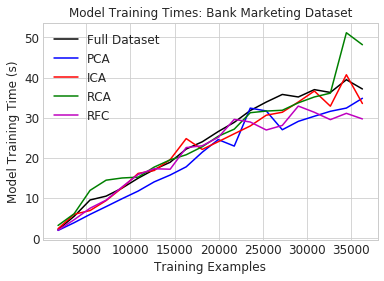

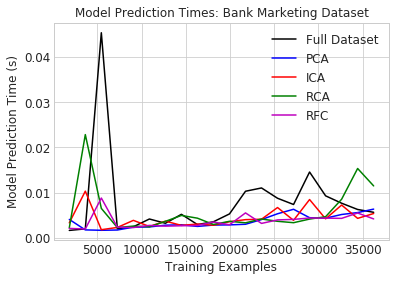

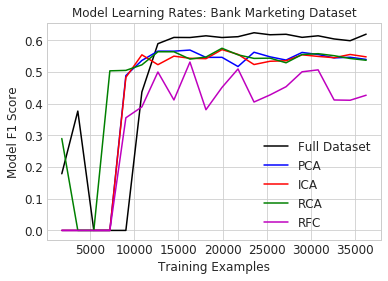

In [126]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Bank Marketing Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Bank Marketing Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Bank Marketing Dataset')  

# 7. Training Neural Network on Projected Data with Cluster Labels

This section will train a neural network on the 4 projected datasets for only the bank marketing data. The difference in this section is that we now add cluster labels from both k-means and EM (after 1-hot encoding) to the reduced datasets. We will examine the learning curves on the training data as well as the final network performance on the test dataset.

In [128]:
def addclusters(X,km_lables,em_lables):
    
    df = pd.DataFrame(X)
    df['KM Cluster'] = km_labels
    df['EM Cluster'] = em_labels
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1)
    new_X = np.array(df.values,dtype='int64')   
    
    return new_X

In [129]:
km = KMeans(n_clusters=20,n_init=10,random_state=100,n_jobs=-1).fit(bankX_scaled)
km_labels = km.labels_
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(bankX_scaled)
em_labels = em.predict(bankX_scaled)

clust_full = addclusters(bankX_scaled,km_labels,em_labels)
clust_pca = addclusters(pca_bank,km_labels,em_labels)
clust_ica = addclusters(ica_bank,km_labels,em_labels)
clust_rca = addclusters(rca_bank,km_labels,em_labels)
clust_rfc = addclusters(rfc_bank,km_labels,em_labels)

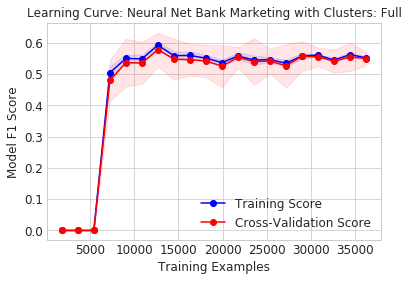

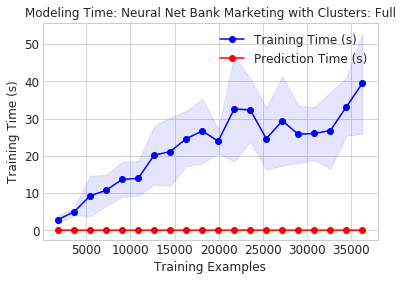

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   14.88767
F1 Score:  0.54
Accuracy:  0.90     AUC:       0.73
Precision: 0.57     Recall:    0.51
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.01450

F1 Score:  0.54
Accuracy:  0.90     AUC:       0.74
Precision: 0.56     Recall:    0.53
*****************************************************


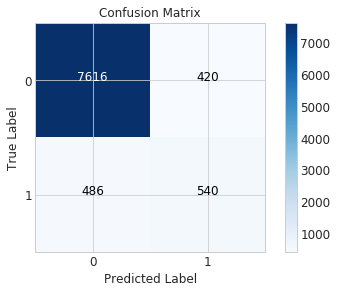

In [130]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_full),np.array(bankY), test_size=0.20, random_state = 3)
full_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full = plot_learning_curve(full_est, X_train, y_train,title="Neural Net Bank Marketing with Clusters: Full")
final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test)

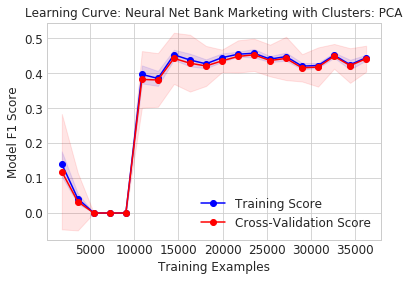

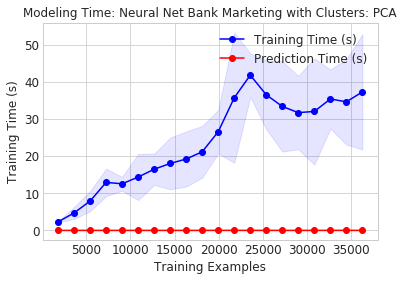

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   16.85914
F1 Score:  0.44
Accuracy:  0.90     AUC:       0.66
Precision: 0.60     Recall:    0.34
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00857

F1 Score:  0.45
Accuracy:  0.90     AUC:       0.66
Precision: 0.61     Recall:    0.35
*****************************************************


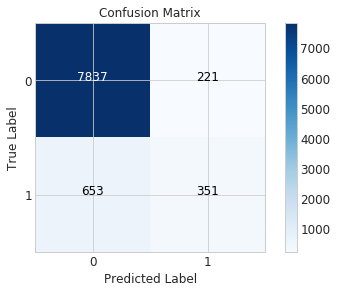

In [131]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_pca),np.array(bankY), test_size=0.20, random_state =3)
pca_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca = plot_learning_curve(pca_est, X_train, y_train,title="Neural Net Bank Marketing with Clusters: PCA")
final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test)

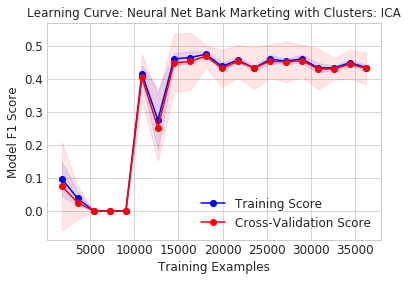

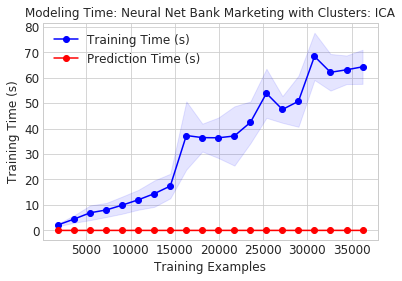

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   88.76880
F1 Score:  0.45
Accuracy:  0.90     AUC:       0.66
Precision: 0.60     Recall:    0.36
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.04273

F1 Score:  0.42
Accuracy:  0.90     AUC:       0.65
Precision: 0.59     Recall:    0.33
*****************************************************


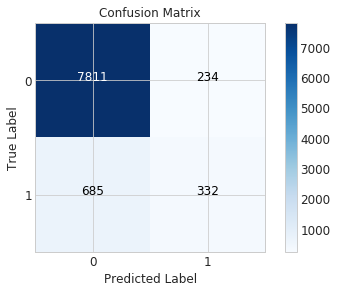

In [133]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_ica),np.array(bankY), test_size=0.20, random_state =3)
ica_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica = plot_learning_curve(ica_est, X_train, y_train,title="Neural Net Bank Marketing with Clusters: ICA")
final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test)

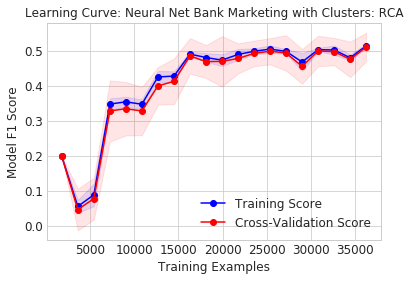

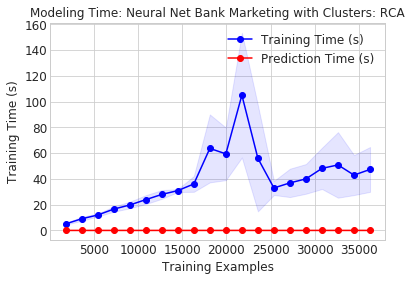

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   21.06019
F1 Score:  0.48
Accuracy:  0.90     AUC:       0.69
Precision: 0.58     Recall:    0.41
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.01659

F1 Score:  0.49
Accuracy:  0.90     AUC:       0.69
Precision: 0.58     Recall:    0.42
*****************************************************


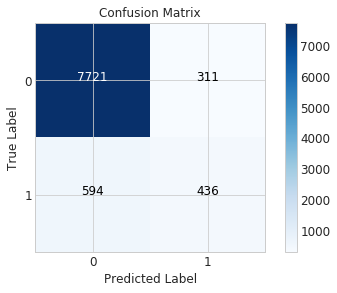

In [134]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rca),np.array(bankY), test_size=0.20, random_state =3)
rca_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_rca, NN_train_score_rca, NN_fit_time_rca, NN_pred_time_rca = plot_learning_curve(rca_est, X_train, y_train,title="Neural Net Bank Marketing with Clusters: RCA")
final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test)

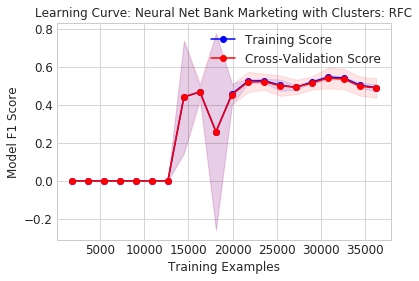

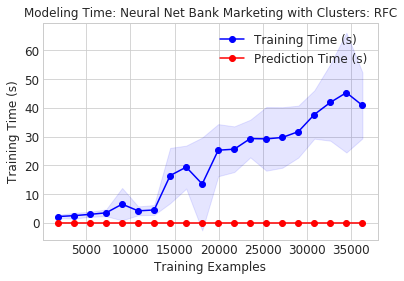

Model Evaluation Metrics Using Train Dataset
*****************************************************
Model Training Time (s):   22.65853
F1 Score:  0.53
Accuracy:  0.91     AUC:       0.71
Precision: 0.60     Recall:    0.46
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00525

F1 Score:  0.51
Accuracy:  0.90     AUC:       0.71
Precision: 0.58     Recall:    0.45
*****************************************************


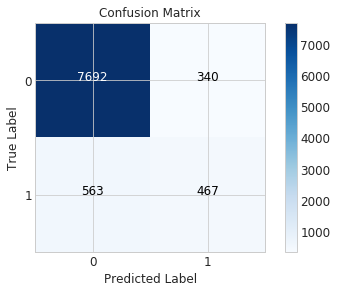

In [135]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rfc),np.array(bankY), test_size=0.20, random_state =3)
rfc_est = MLPClassifier(hidden_layer_sizes=(2,2,2,2), solver='adam', activation='tanh', 
                               learning_rate_init=1e-4, random_state=100)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc = plot_learning_curve(rfc_est, X_train, y_train,title="Neural Net Bank Marketing with Clusters: RFC")
final_classifier_evaluation(rfc_est, X_train, X_test, y_train, y_test)

Evaluate new datasets with cluster labels added.

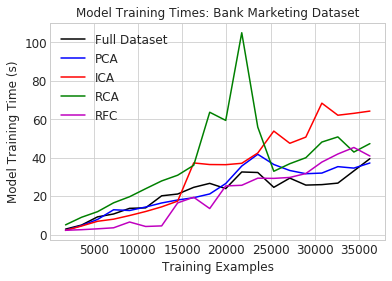

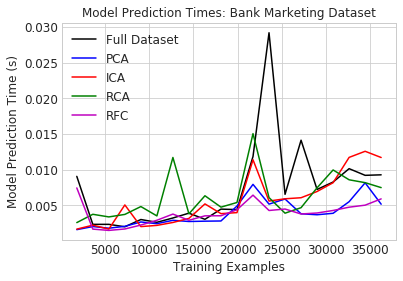

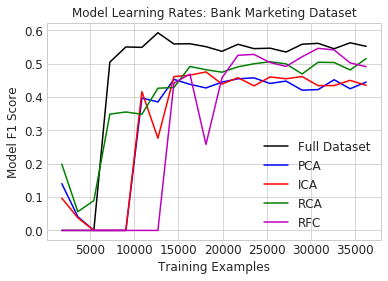

In [136]:
compare_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, 
                 NN_fit_time_rca, NN_fit_time_rfc, 'Bank Marketing Dataset')              
compare_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, 
                 NN_pred_time_rca, NN_pred_time_rfc, 'Bank Marketing Dataset')   
compare_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, 
                 NN_train_score_rca, NN_train_score_rfc, 'Bank Marketing Dataset')  